In [9]:
import scipy.io 
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as spd
import matplotlib.pyplot as plt
import numpy as np
import skeletons
import skeletons_utils
import embeddings
import clustering
import visualizations
import cv2

# Skeletons 

In [10]:
m = scipy.io.loadmat('./datasets/dauphine/dauphine_long_skel.mat')
video_path = './datasets/dauphine/dauphine_long.mp4'
giroslow_flag = False

In [ ]:
imputed_data = skeletons.value_imputation(m['skeldata'].T)
#imputed_data = np.load('dauphine_long_skel.npy')

In [12]:
u, s, v = np.linalg.svd(imputed_data, full_matrices=False)
print(u.shape, s.shape, v.shape)
#print(s)

rank = skeletons.rank_detection(s, 0.999)
print(rank)

# remove outliers
clean_data, outliers_indexes = skeletons.remove_outliers(imputed_data, rank, u, s, v)
print(clean_data.shape)

#reduce dimensions
reduced_data = skeletons.reduce_dimensions(clean_data, rank)
print(reduced_data.shape)

#last task in pre-processing skeleton data is to re add the frame index and syncronize it with image embeddings data for giroslow dataset
final_skel_data = skeletons.readd_index(m['skeldata'].T ,outliers_indexes, reduced_data, giroslow_flag) #this function also synchronizes the indexes from frames in image embeddings and skeleton data
print(final_skel_data.shape)

(28232, 36) (36,) (36, 36)
20
Percentage of removed outliers =  1.187 %
(27897, 36)
(27897, 20)
(27897, 21)


In [13]:
frames, no_skeletons = skeletons.number_skeletons_per_frame(final_skel_data)

Clustering

In [ ]:
clustering.dendograma(reduced_data, 'complete')

In [ ]:
clustering.dendograma(reduced_data, 'ward')

In [ ]:
# Calculate the pairwise distances between data points
dist_matrix = spd.pdist(reduced_data)

# Perform centroid-based hierarchical clustering
Z = sch.linkage(dist_matrix, method='centroid')

# Generate the dendrogram
dendrograms = sch.dendrogram(Z)

In [ ]:
"""
wcss = clustering.k_means(reduced_data, 50)

import matplotlib.pyplot as plt
# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()
"""

In [29]:
no_clusters_only_skeletons = 8

In [30]:
skeleton_clusters = clustering.agglomerative_clustering(reduced_data, no_clusters_only_skeletons)

In [31]:
skel_frame_clusters = clustering.get_clusters_by_frame(skeleton_clusters, no_clusters_only_skeletons)

[1860 1105 4381 2554 1058]


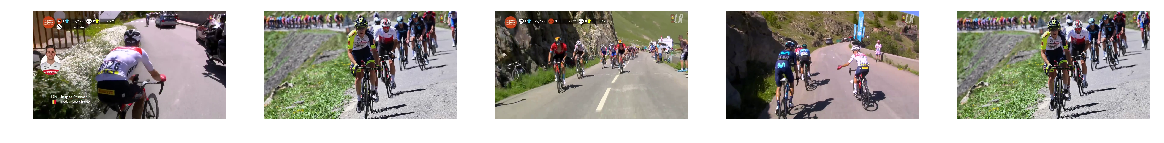

In [32]:
show_cluster = 3
num_examples = 5
visualizations.show_cluster_examples(video_path, skel_frame_clusters, show_cluster, num_examples)

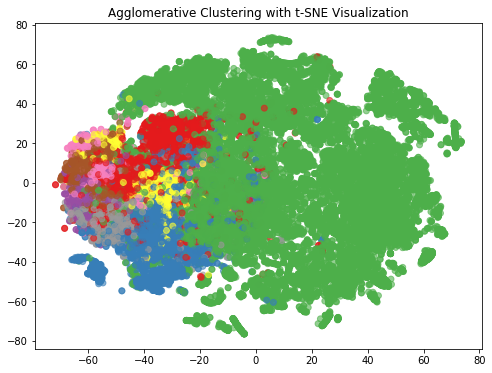

In [33]:
visualizations.tsne(reduced_data, skeleton_clusters)

# Image embeddings

In [18]:
m = scipy.io.loadmat('./datasets/dauphine/dauphine_long_features.mat')
print(m['features'].T.shape)
m = m['features'].T

(10734, 2048)


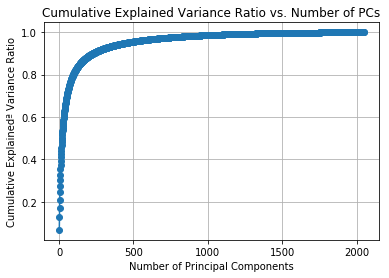

Number of components necessary for  80.0 %% cumulative explained percentage is  95
Shape of reduced_data: (10734, 95)
(10734, 95)


In [19]:
img_features = embeddings.center_and_scale(m)
img_data = embeddings.PCA_images(img_features, 0.8)
print(img_data.shape)

In [20]:
u, s, v = np.linalg.svd(img_data, full_matrices=False)
print(u.shape, s.shape, v.shape)
#print(s)

rank = skeletons.rank_detection(s, 0.999)
print(rank)

# remove outliers
image_data, outliers_indexes = skeletons.remove_outliers(img_data, rank, u, s, v)
print(image_data.shape)

(10734, 95) (95,) (95, 95)
95
Percentage of removed outliers =  1.025 %
(10624, 95)


Clustering

In [ ]:
clustering.dendograma(image_data, 'complete')

In [ ]:
clustering.dendograma(image_data, 'ward')

In [ ]:
# Calculate the pairwise distances between data points
dist_matrix = spd.pdist(image_data)

# Perform centroid-based hierarchical clustering
Z = sch.linkage(dist_matrix, method='centroid')

# Generate the dendrogram
dendrograms = sch.dendrogram(Z)

In [ ]:
"""
wcss = clustering.k_means(image_data, 400)

# Elbow Method
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()
""""

In [21]:
no_clusters_only_embeddings = 103 # only embeddings (no skeletons)

In [22]:
img_clusters = clustering.agglomerative_clustering(image_data, no_clusters_only_embeddings)

In [23]:
img_frame_clusters = clustering.get_clusters_by_frame(img_clusters, no_clusters_only_embeddings)

[5933 5941 5898 5883 5924]


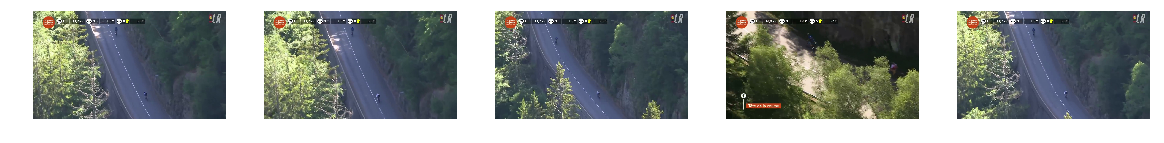

In [25]:
show_cluster = 65
num_examples = 5
visualizations.show_cluster_examples(video_path, img_frame_clusters, show_cluster, num_examples)

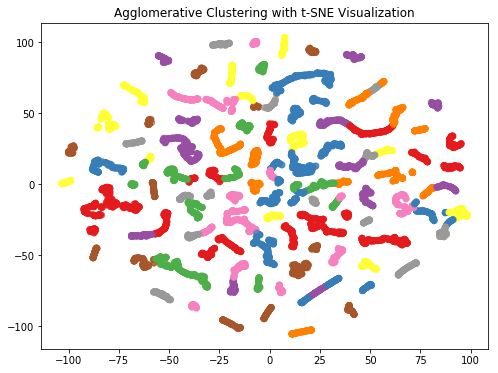

In [26]:
visualizations.tsne(image_data, img_clusters)

# Skeleton + Image embeddings

In [27]:
skeletons.number_skeletons_per_frame(final_skel_data)

(array([    0,     1,     2, ..., 10530, 10531, 10532]),
 array([5, 4, 5, ..., 1, 1, 1]))

In [34]:
matrix = np.zeros((10734, no_clusters_only_skeletons))
skel_frame_clusters = clustering.get_clusters_by_frame(skeleton_clusters, no_clusters_only_skeletons)

for cluster in range(len(skel_frame_clusters)):
    for i in skel_frame_clusters[cluster]:
        matrix[int(final_skel_data[i][0])][cluster] += 1
                   

In [35]:
np.sum(matrix)

27897.0

In [36]:
embeddings_and_skeletons = np.hstack((img_data, matrix))
print(np.shape(embeddings_and_skeletons))

(10734, 103)


In [ ]:
clustering.dendograma(embeddings_and_skeletons, 'ward')

In [ ]:
# Calculate the pairwise distances between data points
dist_matrix = spd.pdist(embeddings_and_skeletons)

# Perform centroid-based hierarchical clustering
Z = sch.linkage(dist_matrix, method='centroid')

# Generate the dendrogram
dendrograms = sch.dendrogram(Z)

For n_clusters = 2 The average silhouette_score is : 0.18153700648282955
For n_clusters = 3 The average silhouette_score is : 0.071872747387081
For n_clusters = 4 The average silhouette_score is : 0.08619204205481609
For n_clusters = 5 The average silhouette_score is : 0.13454946773321166
For n_clusters = 6 The average silhouette_score is : 0.10681716162935903
For n_clusters = 7 The average silhouette_score is : 0.11904931372723941
For n_clusters = 8 The average silhouette_score is : 0.13930760661060135
For n_clusters = 9 The average silhouette_score is : 0.1495452845919164
For n_clusters = 10 The average silhouette_score is : 0.16163502489707565
For n_clusters = 11 The average silhouette_score is : 0.17170593161750225
For n_clusters = 12 The average silhouette_score is : 0.1552562714346029
For n_clusters = 13 The average silhouette_score is : 0.18719474857388244
For n_clusters = 14 The average silhouette_score is : 0.17189850775975576
For n_clusters = 15 The average silhouette_score i

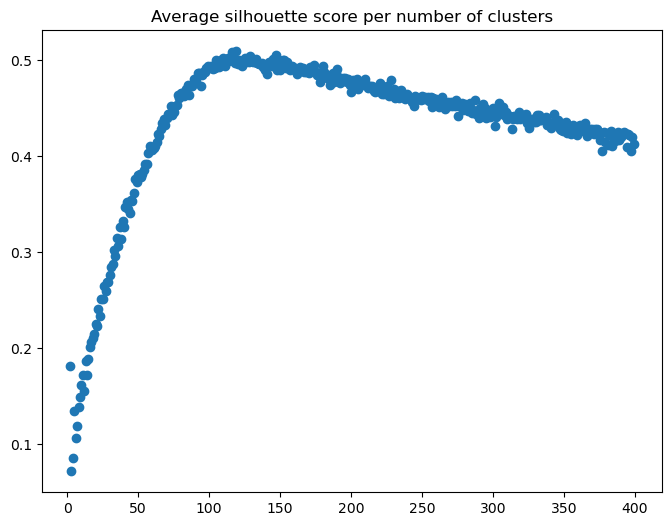

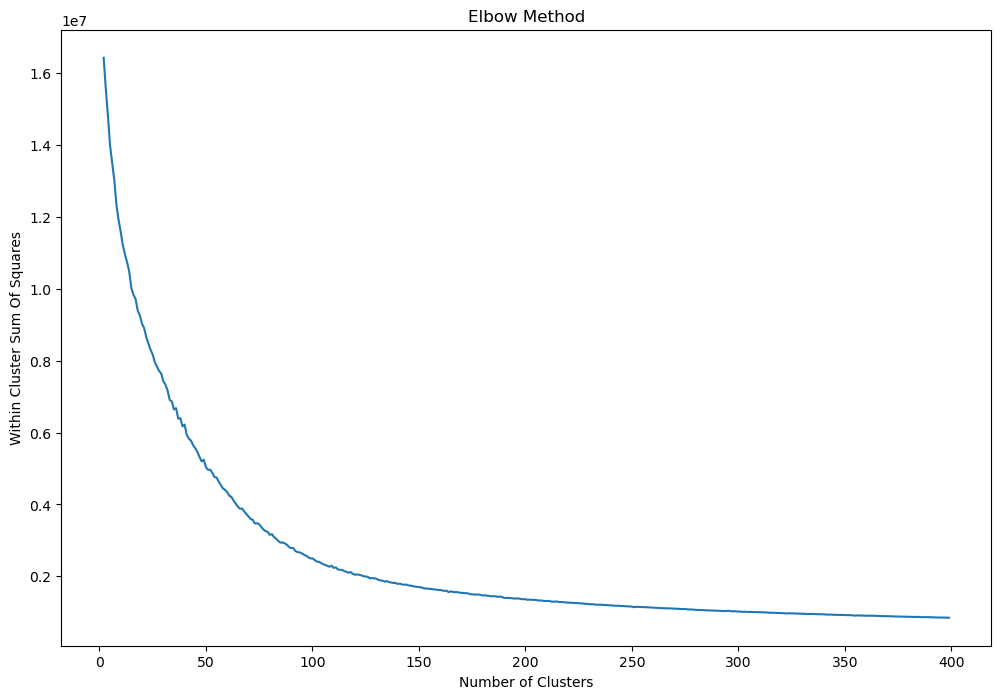

In [23]:
"""
wcss = clustering.k_means(embeddings_and_skeletons, 400)

# Elbow Method
plt.figure(figsize=(12,8))
plt.plot(list(wcss.keys()),list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum Of Squares')
plt.show()
"""

In [37]:
no_clusters_embeddings_and_skeletons = 111

In [38]:
embeddings_and_skeletons_clusters = clustering.agglomerative_clustering(embeddings_and_skeletons, no_clusters_embeddings_and_skeletons)

In [39]:
emb_skel_frame_clusters = clustering.get_clusters_by_frame(embeddings_and_skeletons_clusters, no_clusters_embeddings_and_skeletons)

[9737 9728 9713 9730 9714]


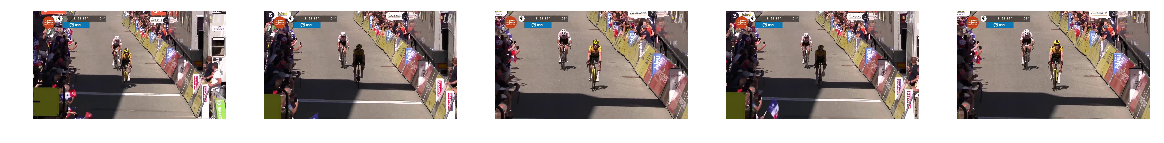

In [55]:
show_cluster = 15
num_examples = 5
visualizations.show_cluster_examples(video_path, emb_skel_frame_clusters, show_cluster, num_examples)

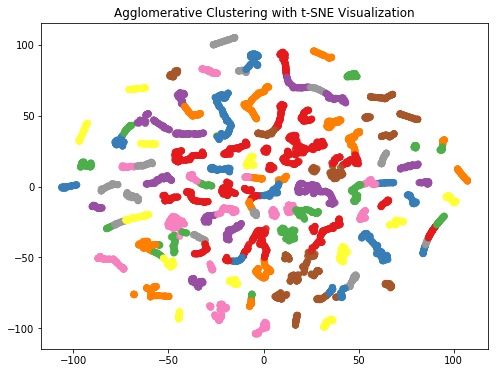

In [41]:
visualizations.tsne(embeddings_and_skeletons, embeddings_and_skeletons_clusters)